In [1]:
import os
import numpy as np

In [2]:
from tqdm import *

In [3]:
import os
import sys
import time
import json
import datetime
import random

from PIL import Image

import numpy as np


class Tub(object):
    """
    A datastore to store sensor data in a key, value format.

    Accepts str, int, float, image_array, image, and array data types.

    For example:

    #Create a tub to store speed values.
    >>> path = '~/mydonkey/test_tub'
    >>> inputs = ['user/speed', 'cam/image']
    >>> types = ['float', 'image']
    >>> t=Tub(path=path, inputs=inputs, types=types)

    """

    def __init__(self, path, inputs=None, types=None):

        self.path = os.path.expanduser(path)
        self.meta_path = os.path.join(self.path, 'meta.json')

        exists = os.path.exists(self.path)

        if exists:
            #load log and meta
            print("Tub does exist")
            with open(self.meta_path, 'r') as f:
                self.meta = json.load(f)
            self.current_ix = self.get_last_ix() + 1

        elif not exists and inputs:
            print('tub does NOT exist')
            #create log and save meta
            os.makedirs(self.path)
            self.meta = {'inputs': inputs, 'types': types}
            with open(self.meta_path, 'w') as f:
                json.dump(self.meta, f)
            self.current_ix = 0
        else:
            raise AttributeError('The path doesnt exist and you pass meta info.')

        self.start_time = time.time()


    def get_last_ix(self):
        index = self.get_index()
        last_index = max(index)
        print("max index: "+str(last_index))
        return last_index

    def get_index(self, shuffled=True):
        files = next(os.walk(self.path))[2]
        record_files = [f for f in files if f[:6]=='record']
        
        def get_file_ix(file_name):
            try:
                name = file_name.split('.')[0]
                num = int(name.split('_')[1])
            except:
                num = 0
            return num

        nums = [get_file_ix(f) for f in record_files]
        
        if shuffled:
            random.shuffle(nums)
        else:
            nums = sorted(nums)
            
        return nums 


    @property
    def inputs(self):
        return list(self.meta['inputs'])

    @property
    def types(self):
        return list(self.meta['types'])

    def get_input_type(self, key):
        input_types = dict(zip(self.inputs, self.types))
        return input_types.get(key)

    def write_json_record(self, json_data):
        path = self.get_json_record_path(self.current_ix)
        try:
            with open(path, 'w') as fp:
                json.dump(json_data, fp)
                #print('wrote record:', json_data)
        except TypeError:
            print('troubles with record:', json_data)
        except:
            print("Unexpected error:", sys.exc_info()[0])
            raise

    def get_json_record_path(self, ix):
        return os.path.join(self.path, 'record_'+str(ix)+'.json')

    def get_json_record(self, ix):
        path = self.get_json_record_path(ix)
        with open(path, 'r') as fp:
            json_data = json.load(fp)
        return json_data

    def put_record(self, data):
        """
        Save values like images that can't be saved in the csv log and
        return a record with references to the saved values that can
        be saved in a csv.
        """
        json_data = {}
        
        for key, val in data.items():
            typ = self.get_input_type(key)

            if typ in ['str', 'float', 'int', 'boolean']:
                json_data[key] = val

            elif typ is 'image':
                path = self.make_file_path(key)
                val.save(path)
                json_data[key]=path

            elif typ == 'image_array':
                img = Image.fromarray(np.uint8(val))
                name = self.make_file_name(key, ext='.jpg')
                img.save(os.path.join(self.path, name))
                json_data[key]=name

            else:
                msg = 'Tub does not know what to do with this type {}'.format(typ)
                raise TypeError(msg)

        self.write_json_record(json_data)
        self.current_ix += 1

    def get_record(self, ix):

        json_data = self.get_json_record(ix)
        data={}
        for key, val in json_data.items():
            typ = self.get_input_type(key)

            #load objects that were saved as separate files
            if typ == 'image':
                val = Image.open(os.path.join(self.path, val))
            elif typ == 'image_array':
                img = Image.open(os.path.join(self.path, val))
                val = np.array(img)

            data[key] = val

        return data


    def make_file_name(self, key, ext='.png'):
        name = '_'.join([str(self.current_ix), key, ext])
        name = name = name.replace('/', '-')
        return name

    def delete(self):
        """ Delete the folder and files for this tub. """
        import shutil
        shutil.rmtree(self.path)

    def shutdown(self):
        pass


    def get_records(self, index=None, record_transform=None):
        if index==None:
            index=self.get_index(shuffled=True)
        
        records = []
        for i in tqdm(index):
            record = self.get_record(i)
            if record_transform:
                record = record_transform(record)
            records.append(record)
        return records


In [4]:
#testing record_gen
tub = Tub("/home/apil/Git/donkey_train/tub_data/left_lane_hive_track_09_02_2017_tkramer")

Tub does exist
max index: 17965


In [5]:
records = tub.get_records()

100%|██████████| 17966/17966 [00:09<00:00, 1804.84it/s]


In [6]:
n_records = len(records)

In [7]:
img_shape = records[0]['cam/image_array'].shape

In [8]:
print(img_shape)

(120, 160, 3)


In [9]:
x_data = np.zeros((n_records,*img_shape))

In [10]:
n_angles = 15

In [11]:
y_data = np.zeros((n_records,n_angles))

In [12]:
def linear_bin(a):
    a = a + 1
    b = round(a / (2/14))
    arr = np.zeros(15)
    arr[int(b)] = 1
    return arr


In [13]:
for i in tqdm(range(len(records))):
    x_data[i,:,:,:] = records[i]['cam/image_array']
    y_data[i,:] = linear_bin(records[i]['user/angle'])

100%|██████████| 17966/17966 [00:01<00:00, 12162.52it/s]


In [14]:
np.save("x_data.npy",x_data)

In [15]:
np.save("y_data.npy",y_data)

/home/apil/anaconda3/envs/pytorch/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


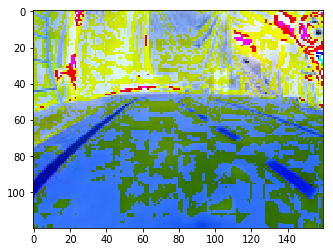

In [16]:
from matplotlib import pyplot as plt
plt.imshow(x_data[115]);plt.show()